In [72]:
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [16]:
dataset_dir = "images_dataSAT"

In [ ]:
img_size = 64
validation_split = 0.2
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=validation_split
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)

train_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_ds = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


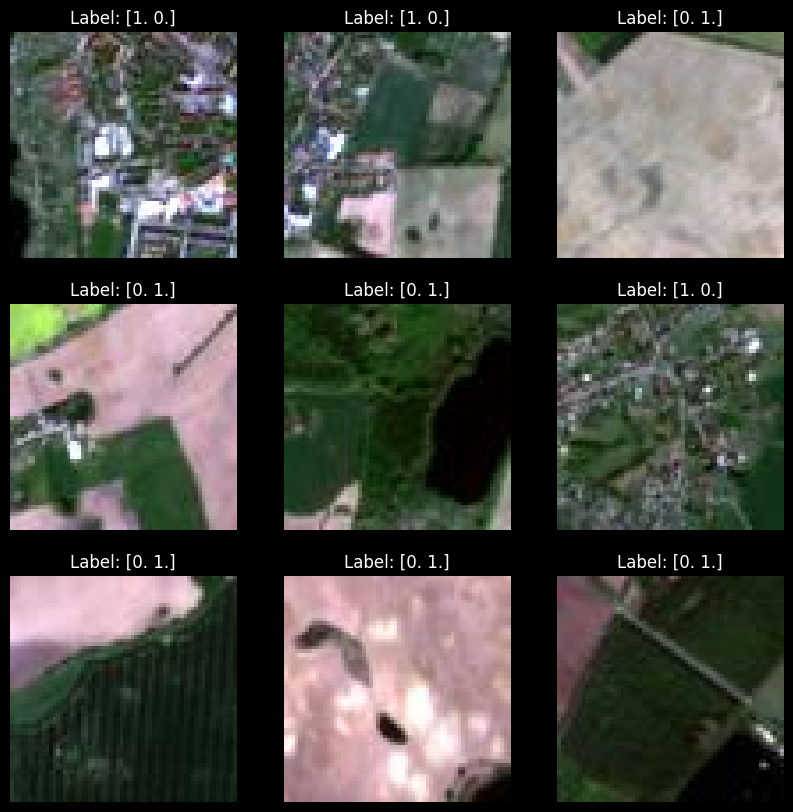

In [58]:
n_samples = 9

fig, axes = plt.subplots(nrows=n_samples // 3, ncols=3, figsize=(10, 10))

# fix the error
images, labels = val_ds[0]
for i, ax in zip(range(n_samples), axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis("off")

In [73]:
model = models.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    layers.Conv2D(16, (5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(8, activation="relu"),
    layers.Dense(len(train_ds.class_indices), activation=None)
])

In [74]:
loss = CategoricalCrossentropy(from_logits=True)
lr = 0.001

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss=loss,
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 16)     │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,274 (106.54 KB)

 Trainable params: 27,146 (106.04 KB)

 Non-trainable params: 128 (512.00 B)

In [75]:
epochs = 3

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/3
12/38 ━━━━━━━━━━━━━━━━━━━━ 1:24 3s/step - accuracy: 0.7632 - loss: 0.5122

KeyboardInterrupt: 

In [ ]:
# plot accuracy and loss for train and val

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(epochs)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# code for classifccation report and confusion matrix 

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

val_ds.reset()
Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)
print("Classification Report")
print(classification_report(val_ds.classes, y_pred, target_names=val_ds.class_indices.keys()))

print("Confusion Matrix")
cm = confusion_matrix(val_ds.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_ds.class_indices.keys(), yticklabels=val_ds.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()